# Examining Influential Factors On Poverty Status

## Random Forest Modeling

#### Notebook overview

In this notebook, two models were used: a Random Forest model and a Random Forest model with resampling. The data was prepared by removing unnecessary information and splitting it into training and test sets. The Random Forest model was trained on the training data, and its performance was evaluated by making predictions on the test data. Metrics such as accuracy and F1 score were utilized to assess the model's accuracy, and a confusion matrix was created to visualize the predictions.

The Random Forest model was chosen due to its ability to handle complex data with multiple factors, handle outliers effectively, and discover non-linear patterns. It also provides insights into the important factors that contribute to predictions. To address imbalanced data, where certain categories have more data than others, the Random Forest model with resampling was employed. Additional examples from the minority categories were added to ensure sufficient data representation. Optimal model settings were determined, and the model's performance was evaluated using accuracy and F1 score. Another confusion matrix was generated to evaluate the resampled model's performance.

By comparing the results of both models, insights were gained into the impact of resampling when dealing with imbalanced data. The analysis of important factors in the Random Forest model provided a better understanding of the factors that significantly influence predictions. Overall, the notebook presented a systematic approach to classification modeling, addressing imbalanced data, and evaluating model performance.

In [1]:
#Imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler
from sklearn.metrics import accuracy_score, balanced_accuracy_score, f1_score, ConfusionMatrixDisplay, confusion_matrix
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, GridSearchCV

In [2]:
#read from github repository
df = pd.read_csv("https://media.githubusercontent.com/media/Rpierre98/DSI-320-Group-Project/main/data/clean_data/cleaned_data.csv")

In [3]:
df.head()

,AGE,STATE,FAM_RELATIONSHIP,OUT_POCKET_NONPREM,OUT_POCKET_OC,OCCUPATION,EDU_LVL,MARITAL,SEX,HOUSEHOLD_SUMMARY,...,CASH_ASSIST,WIC,CHLD_SUP,ADJ_GROSS_INC,TAX_FILE_STAT,HEALTH_INS,PUB_INS,PRIV_INS,POV_STS,POV_LVL
0,42,nonmover,not fam,0,0,Professional,associate degree,single,male,householder,...,under 15,not eligible,0,44220,single,yes,no coverage,covered all year,0,150+ percent of poverty level
1,62,nonmover,ref person,320,48,Business/Finance,high school graduate,married/civilian spouse,male,householder,...,under 15,not eligible,0,80349,joint under 65 y/o,yes,no coverage,covered all year,0,150+ percent of poverty level
2,64,nonmover,spouse,0,100,Professional,bachelor's degree,married/civilian spouse,female,spouse of HH,...,under 15,not eligible,0,0,joint under 65 y/o,yes,no coverage,covered all year,0,150+ percent of poverty level
3,26,nonmover,ref person,0,100,sales,college no degree,married/civilian spouse,male,householder,...,under 15,not eligible,0,60001,joint under 65 y/o,yes,no coverage,covered all year,0,150+ percent of poverty level
4,24,nonmover,spouse,300,100,Professional,college no degree,married/civilian spouse,female,spouse of HH,...,under 15,no,0,0,joint under 65 y/o,yes,no coverage,covered all year,0,150+ percent of poverty level


## Preprocessing

#### Baseline Accuracy

In [4]:
# Count the occurrences of each class in the original dataset
class_counts = df['POV_STS'].value_counts(normalize=True)
class_counts

0    0.927009
1    0.072991
Name: POV_STS, dtype: float64

#### Imbalanced dataset indicating that we need to stratify y so our model performs accurately

In [5]:
# Identify categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns


['STATE',
 'FAM_RELATIONSHIP',
 'OCCUPATION',
 'EDU_LVL',
 'MARITAL',
 'SEX',
 'HOUSEHOLD_SUMMARY',
 'MILITARY',
 'CERT_REQ',
 'TROUB_BATHE',
 'TROUB_HEAR',
 'TROUB_SEE',
 'TROUB_ALONE',
 'TROUB_WALK',
 'TROUB_CONC',
 'HISPANIC',
 'IMMIGR_YR',
 'CITIZENSHIP',
 'DISABLED',
 'RACE',
 'WORK_INDUSTRY',
 'LABOR_STATUS',
 'WRK_STATUS',
 'WRK_CLASS_LONGEST',
 'LONGEST_IND',
 'NO_WRK_RSN',
 'FT_PT',
 'EARN_SOURCE',
 'ERN_OTR',
 'WORK_DIS',
 'DIS_INC',
 'OTH_DIS_INC',
 'FIN_ASSIST',
 'OTH_INC',
 'CASH_ASSIST',
 'WIC',
 'TAX_FILE_STAT',
 'HEALTH_INS',
 'PUB_INS',
 'PRIV_INS',
 'POV_LVL']

In [6]:
#Remove columns that aren't used in modeling process
columns_to_remove = ['HOUSEHOLD_SUMMARY', 'MILITARY', 'TROUB_BATHE', 'TROUB_HEAR', 'TROUB_SEE', 'TROUB_ALONE', 'TROUB_WALK', 'TROUB_CONC', 'STATE', 'CERT_REQ', 'DIS_INC', 'OTH_DIS_INC', 'OTH_INC']
cleaned_df = df.drop(columns=columns_to_remove)

In [7]:
# Identify remaining categorical columns
remaining_categorical_columns = cleaned_df.select_dtypes(include=['object']).columns.tolist()
remaining_categorical_columns

['FAM_RELATIONSHIP',
 'OCCUPATION',
 'EDU_LVL',
 'MARITAL',
 'SEX',
 'HISPANIC',
 'IMMIGR_YR',
 'CITIZENSHIP',
 'DISABLED',
 'RACE',
 'WORK_INDUSTRY',
 'LABOR_STATUS',
 'WRK_STATUS',
 'WRK_CLASS_LONGEST',
 'LONGEST_IND',
 'NO_WRK_RSN',
 'FT_PT',
 'EARN_SOURCE',
 'ERN_OTR',
 'WORK_DIS',
 'FIN_ASSIST',
 'CASH_ASSIST',
 'WIC',
 'TAX_FILE_STAT',
 'HEALTH_INS',
 'PUB_INS',
 'PRIV_INS',
 'POV_LVL']

In [8]:
# Clean remaining categorical columns
cleaned_df[remaining_categorical_columns] = cleaned_df[remaining_categorical_columns].fillna('Unknown')

# Perform one-hot encoding
cleaned_df_encoded = pd.get_dummies(cleaned_df, columns=remaining_categorical_columns)

# Split the encoded df into X and y 
X = cleaned_df_encoded.drop(columns=['POV_STS'])
y = cleaned_df_encoded['POV_STS']


## Random Forest Model

In [9]:
# Split the data 
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [10]:
# Initialize the Random Forest classifier
rf = RandomForestClassifier()

In [11]:
# Train the Random Forest model
rf.fit(X_train, y_train)

RandomForestClassifier()

In [12]:
# Make predictions on the validation data
y_pred = rf.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [13]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

balanced_acc = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_acc}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")

Accuracy: 0.949520411169673
Balanced Accuracy: 0.7651817404842137
F1 Score: 0.6137274549098197


**The accuracy score tells us that the model was correct about 95% of the time. The balanced accuracy score shows that the model did well in predicting different categories, even if some had more data than others. It tried to be fair and accurate for all categories. The F1 score, which measures overall accuracy, tells us that the model balanced being precise and capturing positive cases**. 

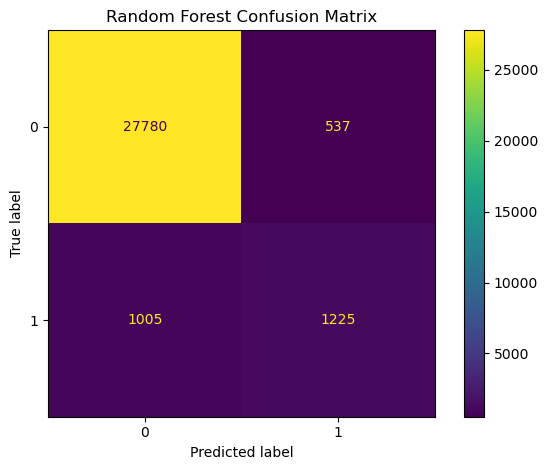

In [14]:
cm = confusion_matrix(y_test, y_pred)


class_labels = np.unique(np.concatenate((y_test, y_pred)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_labels)
disp.plot()
plt.title('Random Forest Confusion Matrix')
plt.tight_layout()
plt.savefig('../images/classification_models/rf_confusion_matrix.png')
plt.show()

## Random Forest W / Resampling 

In [15]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42,stratify=y)

In [16]:
# Create a pipeline with RandomOverSampler and RandomForestClassifier
pipe = Pipeline([
    ('oversampler', RandomOverSampler(random_state=42)),
    ('classifier', RandomForestClassifier())
])

In [17]:
# Define the parameter grid for GridSearchCV
param_grid = {
    'oversampler__sampling_strategy': [0.25, 0.5, 0.75, 1]
}


In [18]:
# Initialize GridSearch
gs = GridSearchCV(pipe, param_grid, n_jobs=-1, scoring='f1')

In [19]:
# Fit the pipeline on the training data
gs.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('oversampler',
                                        RandomOverSampler(random_state=42)),
                                       ('classifier',
                                        RandomForestClassifier())]),
             n_jobs=-1,
             param_grid={'oversampler__sampling_strategy': [0.25, 0.5, 0.75,
                                                            1]},
             scoring='f1')

In [20]:
best_estimator = gs.best_estimator_
best_estimator

Pipeline(steps=[('oversampler',
                 RandomOverSampler(random_state=42, sampling_strategy=0.5)),
                ('classifier', RandomForestClassifier())])

In [21]:
y_pred = best_estimator.predict(X_test)
y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [22]:
accuracy = accuracy_score(y_test, y_pred)
print(f"Accuracy: {accuracy}")

balanced_accuracy = balanced_accuracy_score(y_test, y_pred)
print(f"Balanced Accuracy: {balanced_accuracy}")

f1 = f1_score(y_test, y_pred)
print(f"F1 Score: {f1}")


Accuracy: 0.9437260614790323
Balanced Accuracy: 0.8215451159842976
F1 Score: 0.6377239199157008


**The Random Forest model with resampling in the notebook performed well by balancing the imbalanced data. It achieved a high accuracy of about 94% and successfully predicted both the minority and majority categories with a balanced accuracy score of approximately 82%. The model also maintained a good balance between being precise and capturing positive cases, as indicated by an F1 score of around 0.63**.

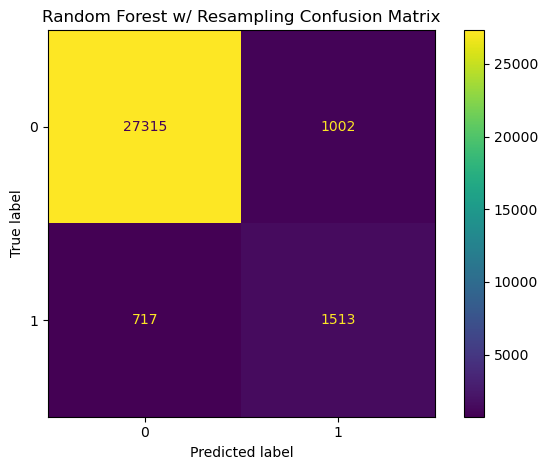

In [23]:
cm = confusion_matrix(y_test, y_pred)

class_labels = np.unique(np.concatenate((y_test, y_pred)))

disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=np.unique(y_test))
disp.plot()
plt.title('Random Forest w/ Resampling Confusion Matrix')
plt.tight_layout()
plt.savefig('../images/classification_models/rf_confusion_matrix_w_resample.png')
plt.show()

The confusion matrix demonstrated improvement in the True Negative values, representing the accurate classification of the Positive class. However, there is room for improvement in reducing both the False positives and False negatives.

## Feature Importances

In [24]:
importances = best_estimator.named_steps['classifier'].feature_importances_
feature_names = X.columns

# Create a DataFrame to display the feature importances
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Exclude the "POV_LVL" column
feature_importance_df = feature_importance_df[~feature_importance_df['Feature'].str.startswith('POV_LVL')]

# Sort the DataFrame by importance in descending order
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

# Print the feature importances
feature_importance_df


,Feature,Importance
0,AGE,5.072352e-02
9,ADJ_GROSS_INC,3.907838e-02
2,OUT_POCKET_OC,3.886254e-02
1,OUT_POCKET_NONPREM,3.509495e-02
4,GROSS_PAY,3.337467e-02
...,...,...
21,OCCUPATION_military,2.712247e-06
88,RACE_White-Black-AI-Asian,1.936740e-06
75,RACE_Black-AI-Asian,1.430334e-06
78,RACE_Other 3 race comb.,6.606924e-08


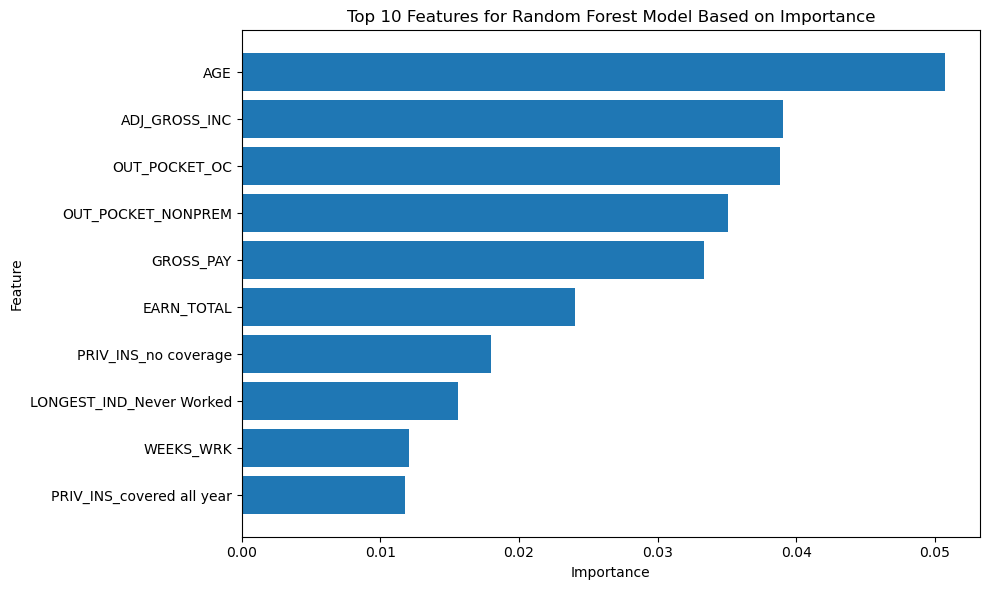

In [25]:
# Plot the top 10 features
plt.figure(figsize=(10, 6))
plt.barh(feature_importance_df['Feature'].head(10)[::-1], feature_importance_df['Importance'].head(10)[::-1])
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.title('Top 10 Features for Random Forest Model Based on Importance')
plt.tight_layout()
plt.savefig('../images/classification_models/rf_top_10_features.png')
plt.show()

## Conclusion

**The analysis of the best performing model revealed that age was the most influential feature in predicting poverty. This finding aligns with our understanding that younger individuals who may not have established financial stability are more susceptible to poverty. Furthermore, older individuals facing increased financial burdens due to healthcare and other factors also face a higher risk of poverty. Adjusted Gross Income and Out-of-Pocket Outpatient Care were identified as the next significant features contributing to the model's predictive power. These findings emphasize the importance of considering age and financial factors, such as income and healthcare expenses, when addressing poverty-related issues.**